In [ ]:
!wget https://zenodo.org/record/3946618/files/1_class_multiscale.pb

--2020-12-19 13:26:13--  https://zenodo.org/record/3946618/files/1_class_multiscale.pb
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169097269 (161M) [application/octet-stream]
Saving to: ‘1_class_multiscale.pb’

1_class_multiscale. 100%[===================>] 161.26M  25.8MB/s    in 6.9s    

2020-12-19 13:26:21 (23.4 MB/s) - ‘1_class_multiscale.pb’ saved [169097269/169097269]



In [ ]:
import cv2
import matplotlib.pyplot as plt

import logging
import os
import pickle
import tensorflow as tf
import csv
import os
import numpy as np

from skimage.measure import regionprops
from skimage.io import imsave, imread, ImageCollection
from skimage.morphology import convex_hull_image
from skimage.transform import rescale

In [ ]:
def measure_traits(mask,
                   image,
                   scale_ratio,
                   file_name,
                   ignore_label,
                   labels):
  """Calculates traits from plant rosette segmentations.
  Args:
    mask: Array representing a segmentation mask.
    image: Array representing the original image.
    scale_ratio: Float, scale factor of the downscaled image.
    file_name: String, the image filename.
    ignore_label: Integer, pixel value of label to ignore for trait calculation.
    labels: Dict, Key=value pairs of labelname and (grayscale) pixel value.
  """
  def _split_channels(image):
    """Splits an RGB image into single channels.
    Args:
      image: Array representing an RGB image
    Returns:
      Dictionary of color channel arrays
    """
    red = image[:,:,0].astype(np.uint8)
    green = image[:,:,1].astype(np.uint8)
    blue = image[:,:,2].astype(np.uint8)

    return {'red_channel':red,'green_channel':green,'blue_channel':blue}

  def _check_mask_dimensions(image, mask, filename):
    """Validates image and corresponding mask dimensions. Raises error in case of mismatch.
    Args:
      image: Array representing an RGB image
      mask: Array representing a segmentation mask
    """
    if len(mask.shape) > 2:
      raise SystemExit(f'ERROR: Mask {filename} appears to contain color channels, only grayscale masks are supported!')
    elif image.shape[:2] != mask.shape:
      raise SystemExit(f'ERROR: Could not process image {filename}. Dimensions of image and mask have to match!')

  def _calculate_color_indices(channel_values, mask, label_name, ignore_label):
    """Calculates color channel indices within a segmented mask following Del Valle et al. (2018).
    Args:
      channel_values: Dict, contains 2D-arrays of red, green and blue channel intensities
      mask: Array representing a segmentation mask.
      label_name: String, name of label class.
      ignore_label: Integer, pixel value of label to ignore for trait calculation.
      value: Integer, pixel value of label class.
    Returns:
      Dictionary of values
    """
    stats = {}
    label_mask = create_bool_mask(mask, label_name, ignore_label)
    for channel,values in channels.items():
      stats[channel] = np.mean(values[label_mask])
    stats['chroma_ratio'] = stats['green_channel'] / ((stats['blue_channel'] + stats['red_channel']) / 2)
    stats['chroma_difference'] = ((stats['blue_channel'] + stats['red_channel']) / 2) - stats['green_channel']
    stats['chroma_base'] = (stats['blue_channel'] + stats['red_channel']) / stats['green_channel']
    stats['green_strength'] = stats['green_channel'] / (stats['red_channel'] + stats['green_channel'] + stats['blue_channel'])
    stats['blue_green_ratio'] = stats['blue_channel'] / stats['green_channel']

    return {f'{label_name}_{k}': v for k, v in stats.items()}

  def _calculate_morphometry(mask, label_name, value, scale_ratio, ignore_label):
    """Calculates morphometric traits using scikit-image.
    Args:
      mask: Array representing a segmentation mask.
      channel_values: Dict, contains 2D-arrays of red, green and blue channel intensities
      label_name: String, name of label class.
      value: Integer, pixel value of label class.
      scale_ratio: Float, scale factor of a previously downscaled image.
      ignore_label: Integer, pixel value of label to ignore for trait calculation.
    Returns:
      Dictionary of values
    """
    traits = {}
    traitlist = ['area',
                 'filled_area',
                 'convex_area',
                 'equivalent_diameter',
                 'major_axis_length',
                 'minor_axis_length',
                 'perimeter',
                 'eccentricity',
                 'extent',
                 'solidity']

    # scale the mask up to the dimensions of the original image if it was downscaled
    if scale_ratio != 1.0:
      mask = rescale(mask, scale_ratio, preserve_range=True, anti_aliasing=False, order=0)

    if value == 0:
      traits['total_area'] = mask.size
      traits['class_background_area'] = np.count_nonzero(mask == value)
      label = 'plant_region'
      label_mask = create_bool_mask(mask, label, ignore_label)
    else:
      label = label_name
      label_mask = create_bool_mask(mask, label, value)

    properties = regionprops(label_mask.astype(np.uint8))
    for trait in traitlist:
      try:
        traits[f'{label}_{trait}'] = properties[0][trait]
      except (IndexError, ValueError):
        traits[f'{label}_{trait}'] = 0 if 'area' in trait else np.nan
    try:
      traits[f'{label}_aspect_ratio'] = traits[f'{label}_major_axis_length'] / traits[f'{label}_minor_axis_length']
    except ZeroDivisionError:
      traits[f'{label}_aspect_ratio'] = np.nan

    return traits

  _check_mask_dimensions(image, mask, file_name)

  filename, filefmt = file_name.rsplit('.', 1)

  frame = {'file' : filename, 'format' : filefmt}

  # split image into red, green and blue channel
  channels = _split_channels(image)

  # get color channel information for whole plant region
  frame.update(_calculate_color_indices(channels, mask, 'plant_region', ignore_label))

  for label, value in labels.items():
    # get morphometric traits
    frame.update(_calculate_morphometry(mask, label, value, scale_ratio, ignore_label))
    # get color channel information for each class except background
    if value == 0:
      continue
    frame.update(_calculate_color_indices(channels, mask, label, value))

  # write pixel counts to csv file
  with open('traits.csv', 'a') as counts:
    Writer = csv.DictWriter(counts, fieldnames=frame.keys(), dialect='unix', quoting=csv.QUOTE_NONE)
    if not counts.tell():
      Writer.writeheader()
    Writer.writerow(frame)

def draw_diagnostics(mask,
                     image,
                     file_name,
                     save_rosette,
                     save_overlay,
                     save_mask,
                     save_hull,
                     ignore_label,
                     labels,
                     colormap=None):
  """Saves diagnostic images to disk.
  Args:
    mask: Array representing the segmented mask
    image: Array representing the original image.
    file_name: String, the image filename.
    save_rosette: Boolean, save cropped rosette to disk.
    save_mask: Boolean, save the prediction to disk.
    save_overlay: Boolean, save the superimposed image and mask to disk.
    save_hull: Boolean, save the convex hull to disk.
    ignore_label: Integer, pixel value of label to ignore for trait calculation.
    labels: Dict, Key=value pairs of labelname and (grayscale) pixel value.
    colormap: List, RGB colormap to use for visualization.
  """
  filename, filefmt = file_name.rsplit('.', 1)

  if isinstance(colormap, list):
    cmap = np.array(colormap)
    if cmap.sum() == 2236:
      np.random.shuffle(cmap)
  else:
    # fallback to default
    cmap = np.array([[0,0,0],[31,158,137],[253,231,37],[72,40,120]])

  if len(labels) < max(labels.values()):
    for l, v in enumerate(labels.values()):
      mask[mask == v] = l

  colored_mask = cmap[mask]

  if save_rosette:
    crop = image[:,:,:3] * (mask > 0)[...,None]
    imsave('crop_%s.jpeg' % filename, crop.astype(np.uint8))

  if save_mask:
    imsave('mask_%s.png' % filename, colored_mask.astype(np.uint8))

  if save_overlay:
    overlay = 0.6 * image[:,:,:3] + 0.4 * colored_mask
    imsave('overlay_%s.jpeg' % filename, overlay.astype(np.uint8))

  if save_hull:
    bool_mask = create_bool_mask(mask, 'plant_region', ignore_label)
    hull = convex_hull_image(bool_mask)*255
    convex_hull = 0.6 * colored_mask + 0.4 * np.stack((hull,)*3, axis=-1)
    imsave('hull_%s.png' % filename, convex_hull.astype(np.uint8))

def load_images():
  """Loads ImageCollection into memory
  Returns:
    Two instances of skimage.io.ImageCollection
  """
  def _loader(f):
    return imread(f).astype(np.uint8)

  masks = ImageCollection('raw_masks/*',load_func=_loader)
  originals = ['image/' + os.path.basename(i).rsplit('.', 1)[0] + '.*' for i in masks.files]
  originals = ImageCollection(originals,load_func=_loader)

  return masks, originals

def create_bool_mask(mask, label, ignore_label):
  """Creates a boolean mask for plant region or individual class.
  Args:
    mask: Array representing a mask with integer labels
    ignore_label: Integer, pixel value of label to exclude.
    label: String, which label to return. 'plant_region' returns mask for whole plant.
  Returns:
    Array of type numpy.bool_
  """
  if label == 'plant_region':
    bool_mask = (mask > 0) if ignore_label is None else (mask > 0) & (mask != ignore_label)
  else:
    bool_mask = (mask == ignore_label)

  return bool_mask

In [ ]:
def wrap_frozen_graph(graph_def, inputs, outputs):
  def _imports_graph_def():
    tf.compat.v1.import_graph_def(graph_def,name="")


  wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
  import_graph = wrapped_import.graph
  return wrapped_import.prune(
      tf.nest.map_structure(import_graph.as_graph_element, inputs),
      tf.nest.map_structure(import_graph.as_graph_element, outputs))

def create_record(image_data, filename, height, width, ratio):
    def _bytes_feature(value):
        if isinstance(value, str):
            value = value.encode()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def _float_feature(value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

    features = {
        'image/original': _bytes_feature(image_data),
        'image/filename': _bytes_feature(filename),
        'image/height': _int64_feature(height),
        'image/width': _int64_feature(width),
        'image/resize_ratio': _float_feature(ratio),
        }

    sample = tf.train.Example(features=tf.train.Features(feature=features))
    return sample

def parse_record(record):
    features = {
        'image/original': tf.io.FixedLenFeature((), tf.string),
        'image/filename': tf.io.FixedLenFeature((), tf.string),
        'image/height': tf.io.FixedLenFeature((), tf.int64),
        'image/width': tf.io.FixedLenFeature((), tf.int64),
        'image/resize_ratio': tf.io.FixedLenFeature((), tf.float32)
        }

    parsed = tf.io.parse_single_example(record, features)
    
    image = tf.io.decode_image(parsed['image/original'], channels=3)

    sample = {
    'original': image,
    'filename': parsed['image/filename'],
    'height': parsed['image/height'],
    'width': parsed['image/width'],
    'resize_factor': parsed['image/resize_ratio'],
    }
    return sample

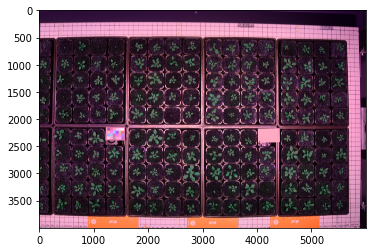

In [ ]:
image = cv2.imread('/content/1.jpg')

plt.imshow(image)
plt.show()

In [ ]:
def crop_roi(path_to_img, output_folder, filename):
    Width = [(340, 640), (640, 940), (940, 1240), (1275, 1575), (1675, 1975), (2000, 2300), (2320, 2620), (2650, 2975),
        (3050, 3375), (3375, 3700), (3700, 4000), (4000, 4350), (4450, 4750), (4750, 5050), (5050, 5350), (5350, 5650)]
    Height = [(525, 840), (840, 1140), (1140, 1440), (1440, 1760), (1760, 2070), (2170, 2470), (2475, 2775),
          (2775, 3100), (3100, 3410), (3425, 3725)]
    
    image = cv2.imread(path_to_img)
    
    idx = 0
    for h_0, h_1 in Height:
        for w_0, w_1 in Width:
            crop_img = image[h_0: h_1, w_0: w_1]
            cv2.imwrite(os.path.join(output_folder , filename + str(idx) +'.jpg'), crop_img)
            idx += 1 

In [ ]:
import os
os.mkdir("image")
crop_roi('1.jpg', 'image', 'img_')

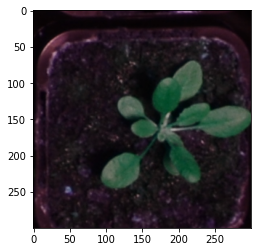

In [ ]:
Height, width = (500, 2150), (250, 1630)
add_y, add_x = 1650, 1380

crop_img = image[3425: 3725, 4750: 5050]

plt.imshow(crop_img)
plt.show()

# cv2.imwrite('image/crop_image.jpg', crop_img)

In [ ]:
logger = tf.get_logger()
logger.propagate = False
logger.setLevel('INFO')

images = tf.io.gfile.glob('/content/image/*')

count = len(images)
invalid = 0
scale_factors = {}

max_dimension = 602
labels = "class_background=0,class_norm=1"

with tf.io.TFRecordWriter('chunk.tfrecord') as writer:
    for i in range(count):
        filename = os.path.basename(images[i])
        image_data = tf.io.gfile.GFile(images[i], 'rb').read()
        try:
            image = tf.io.decode_image(image_data, channels=3)
        except tf.errors.InvalidArgumentError:
            logger.info("%s is either corrupted or not a supported image format" % filename)
            invalid += 1
            with open("invalid.txt", "a") as broken:
                broken.write(f'{filename}\\n')
            continue
        
        max_dimension = 602
        height, width = image.shape[:2]
        ratio = 1.0
        
        if height * width > max_dimension**2:
            logger.info('%s: dimensions %d x %d are too large,' % (filename, height, width))
            ratio = max(height,width)/max_dimension
            new_height = int(height/ratio)
            new_width = int(width/ratio)
            logger.info('%s: resized to %d x %d (scale factor:%f)' % (filename, new_height, new_width, ratio))
            image = tf.image.resize(image, size=[new_height,new_width], preserve_aspect_ratio=False, antialias=True)
            image_data = tf.image.encode_png(tf.cast(image, tf.uint8)).numpy()
            tf.io.write_file(os.path.join(f'images/{filename}'), image_data)
        
        scale_factors[filename] = ratio
        record = create_record(image_data=image_data,
                            filename=filename,
                            height=height,
                            width=width,
                            ratio=ratio)
        
        writer.write(record.SerializeToString())

pickle.dump(scale_factors, open("ratios.p", "wb"))

In [ ]:
import numpy as np

data = np.load("/content/ratios.p", allow_pickle=True)

In [ ]:
import os
os.mkdir("output_img")

In [ ]:
logger = tf.get_logger()
logger.propagate = False
logger.setLevel('INFO')

with tf.io.gfile.GFile('/content/1_class_multiscale.pb', "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

predict = wrap_frozen_graph(
    graph_def,
    inputs='ImageTensor:0',
    outputs='SemanticPredictions:0')

dataset = (
    tf.data.TFRecordDataset('chunk.tfrecord')
    .map(parse_record)
    .batch(1)
    .prefetch(1)
    .enumerate(start=1))

size = len(list(dataset))

for index, sample in dataset:
    filename = sample['filename'].numpy()[0].decode('utf-8')
    logger.info("Running prediction on image %s (%d/%d)" % (filename, index, size))
    raw_segmentation = predict(sample['original'])[0][:, :, None]
    output = tf.image.encode_png(tf.cast(raw_segmentation, tf.uint8))
    tf.io.write_file("/content/output_img/"+filename.rsplit('.', 1)[0] + '.png',output)

INFO:tensorflow:Running prediction on image img_54.jpg (1/160)
INFO:tensorflow:Running prediction on image img_96.jpg (2/160)


In [ ]:
import os
os.mkdir("raw_masks")

FileExistsError: ignored

In [ ]:
!cp /content/output_img/img_54.png -d "/content/raw_masks"

In [ ]:
ratios = pickle.load(open('ratios.p','rb'))
cmap = [[250,140,130],[119,204,98],[240,216,72],[82,128,199],[242,58,58]]
masks, originals = load_images()
ignore_label = None

for index, name in enumerate(originals.files):
    measure_traits(masks[index],
                originals[index],
                ratios[os.path.basename(name)] if ratios is not None else 1.0,
                os.path.basename(name),
                ignore_label=ignore_label,
                labels=dict([( "class_background" , 0 ), ( "class_norm" , 1 )]) )
    draw_diagnostics(masks[index],
                    originals[index],
                    os.path.basename(name),
                    save_overlay='content/',
                    save_mask=True,
                    save_rosette=True,
                    save_hull=True,
                    ignore_label=ignore_label,
                    labels=dict([( "class_background" , 0 ), ( "class_norm" , 1 )]),
                    colormap=cmap
)

In [ ]:
os.path.basename(name)

'1.png'

In [ ]:
originals.files

['image/1.png']

In [ ]:
labels

'class_background=0,class_norm=1'